## EDA часть
## Подготовка и первичный анализ данных новстей interfax и lenta

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
pd.set_option('display.max_colwidth', None)

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Мирослав\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


На данном шаге нам необходимо сделать следующее:
- определить особенности выборки по результатам первичного анализ, удаление выбросов и т.д.
- получить полезную информацию о наших данных и посмотреть на:
  - Распределение по разделам
  - Распределение времени новостей
  - Распределение по длине заголовка
  - Распределение по длине текста
  - Ключевые слова по каждой из тематик


In [5]:
df = pd.read_csv('df_lenta_interfax.csv', parse_dates=['date']).drop(['Unnamed: 0'],axis=1)

In [6]:
df.tail(3)

date    source                                    url  \
488132 2019-01-01  interfax  https://www.interfax.ru/russia/644816   
488133 2019-01-01  interfax   https://www.interfax.ru/world/644814   
488134 2019-01-01  interfax  https://www.interfax.ru/russia/644813   

                                                    title  \
488132  Опознаны пять погибших при обрушении в Магнито...   
488133  Трамп продлил сроки вывода американских войск ...   
488134  Спасатели извлекли из-под завалов в Магнитогор...   

                                                  content   topic  
488132  Пятеро погибших в результате взрыве газа и обр...  Russia  
488133  Президент США Дональд Трамп согласился продлит...   world  
488134  Тела пяти человек извлечены из-под завалов на ...  Russia

### Анализ распределения тематик

Посмотрим на кол-во тематик и их распределение

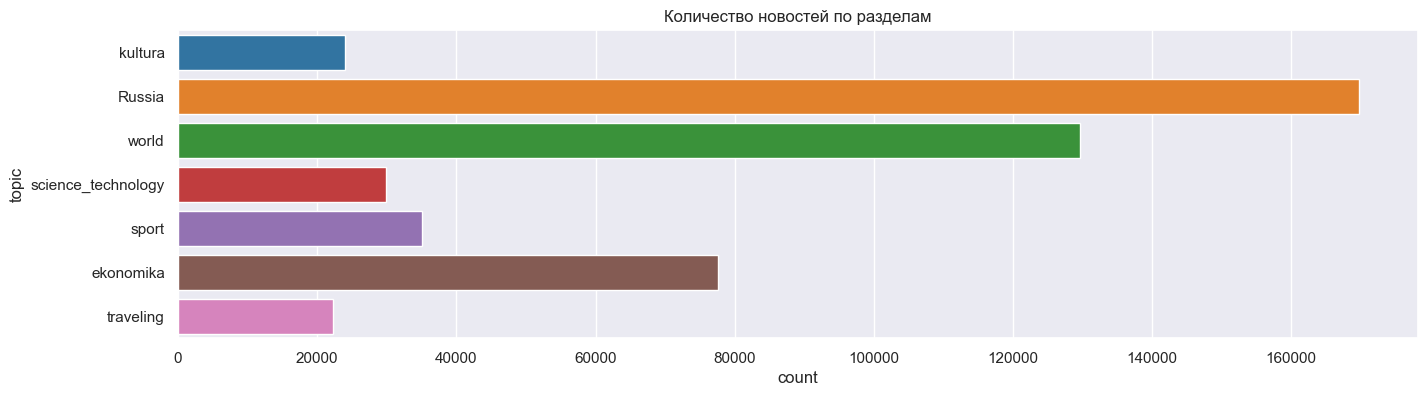

In [7]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df['topic'], palette='tab10', ax=ax)
plt.title('Количество новостей по разделам');

### Распределение новостей по датам

Теперь можно посмотреть на распределние статей по разным срезам

По месяцам и неделям

In [8]:
df['month'] = df['date'].dt.strftime("%B")
df['weekday'] = df['date'].dt.strftime('%A')

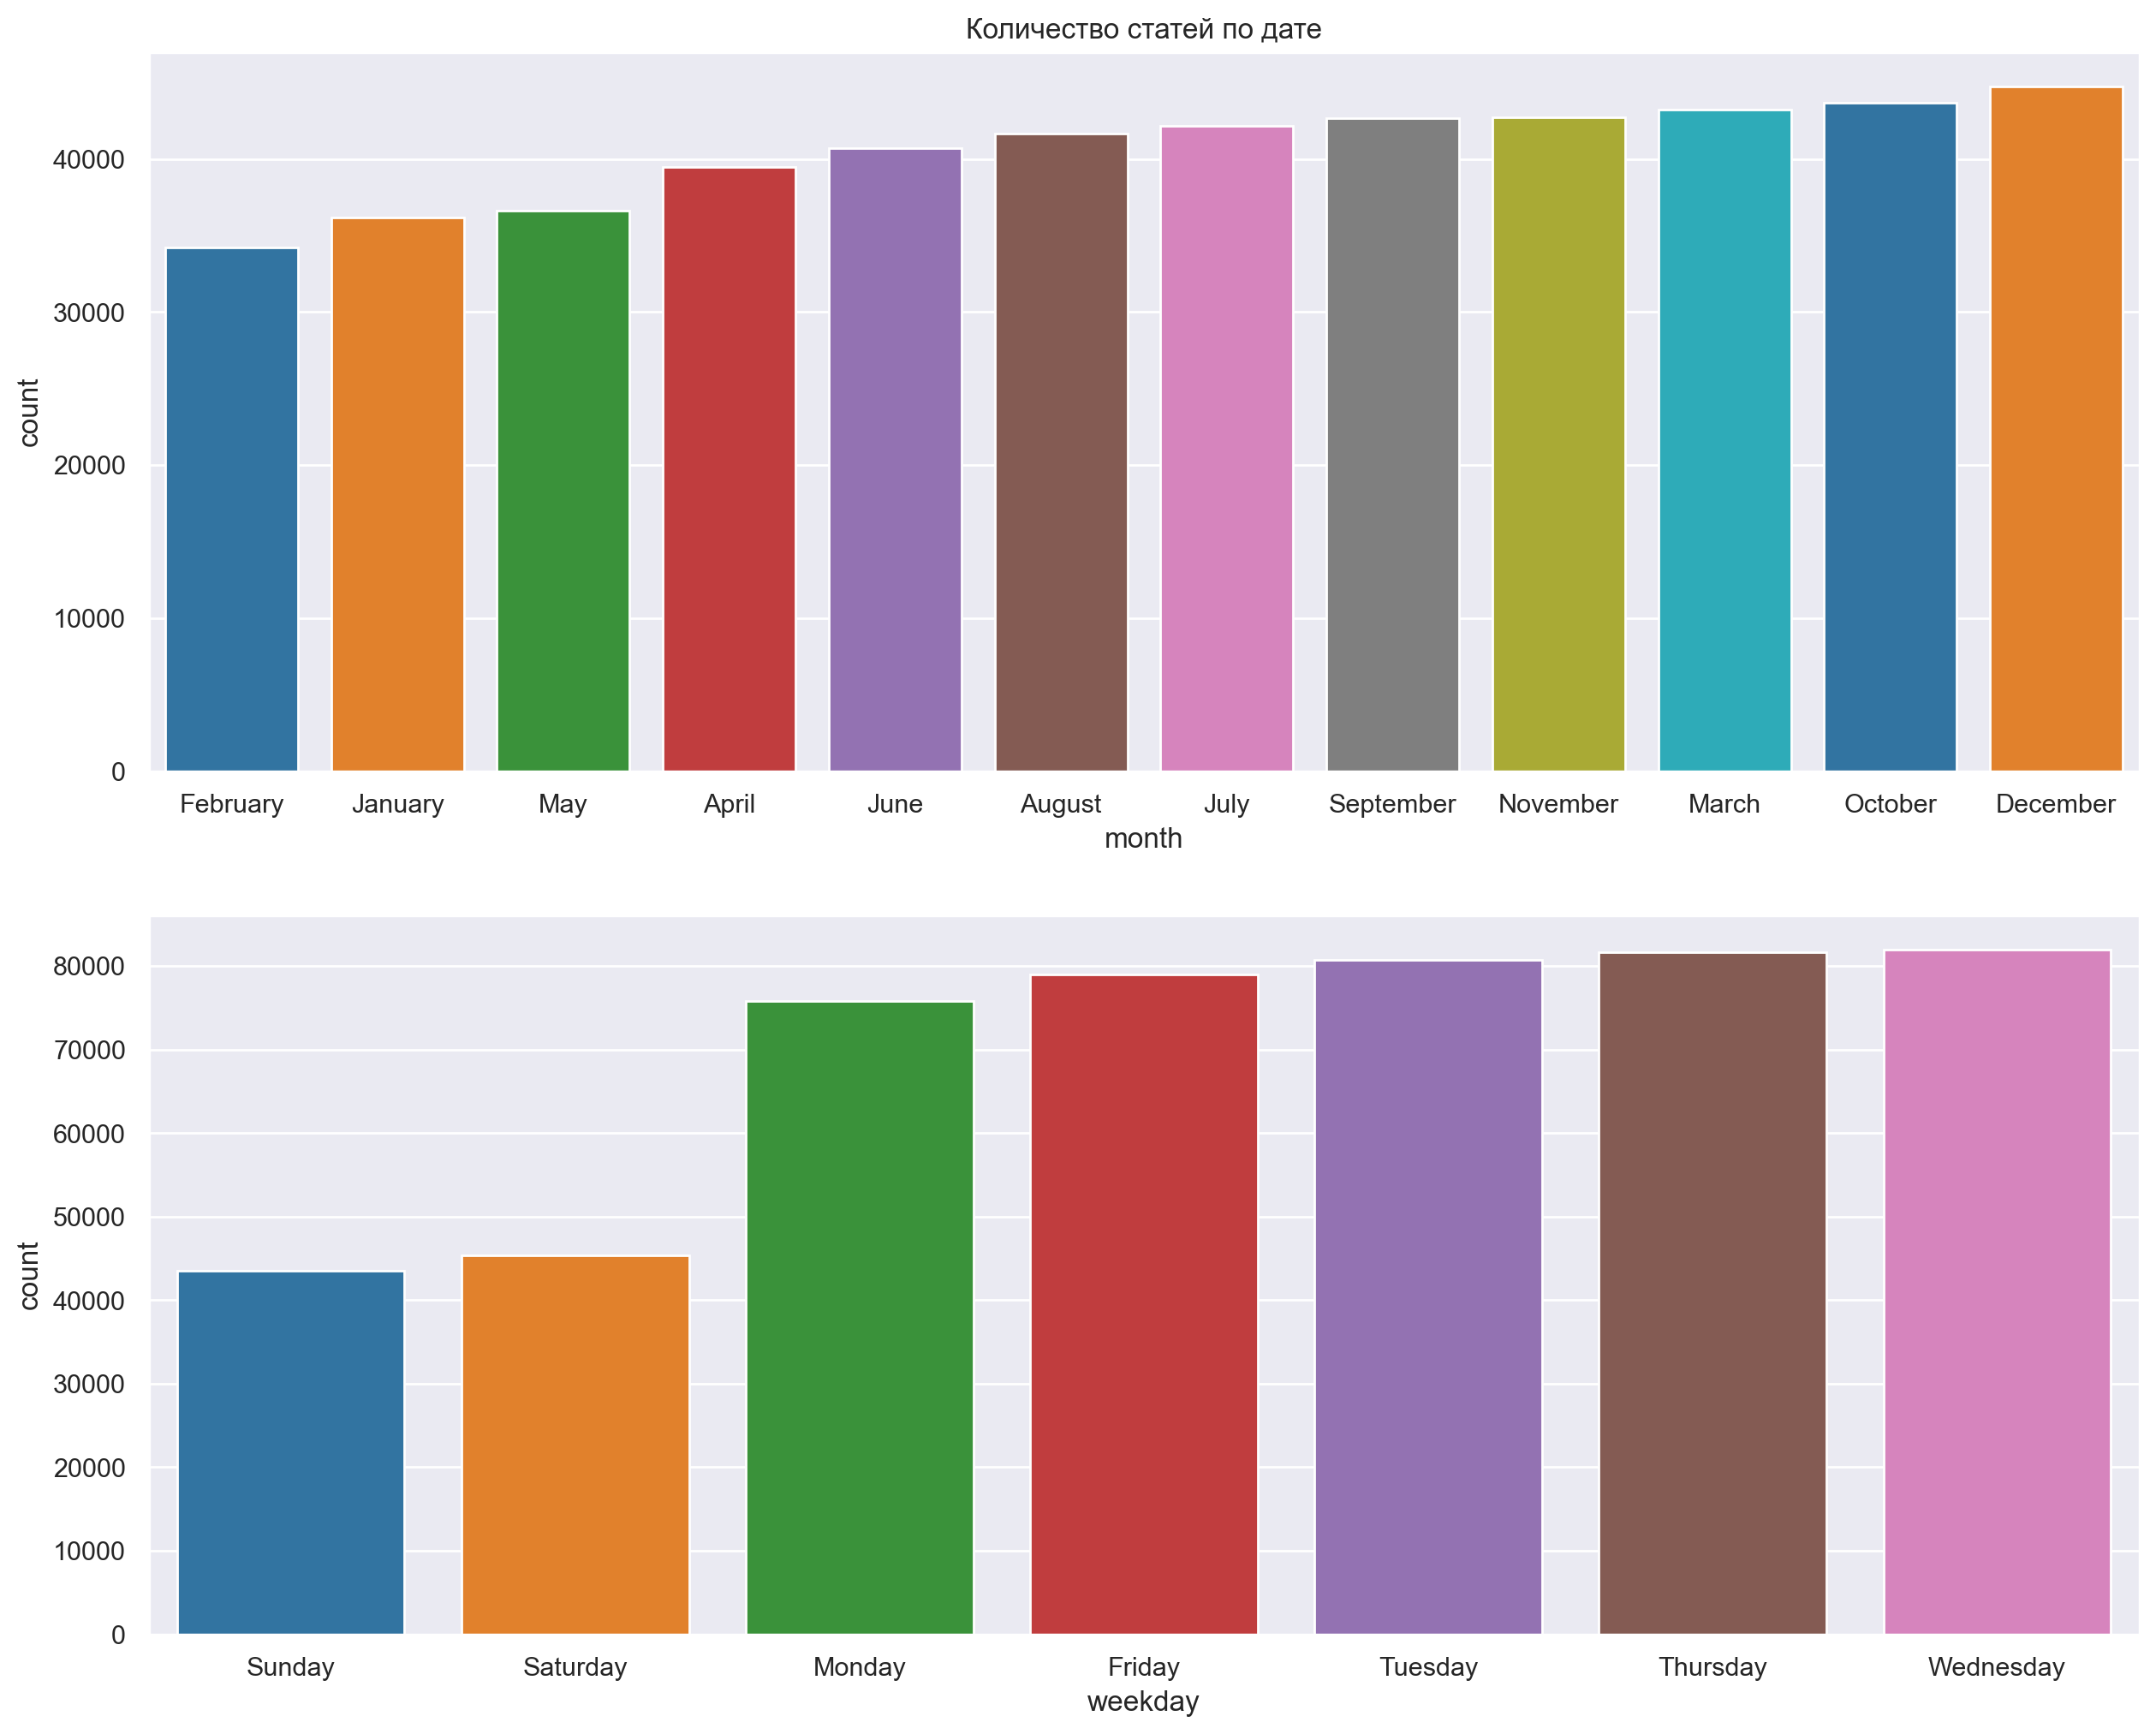

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 12), dpi=200)
for ind, col in enumerate(['month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Количество статей по дате');

По годам

In [25]:
df['year'] = df['date'].dt.strftime('%Y')

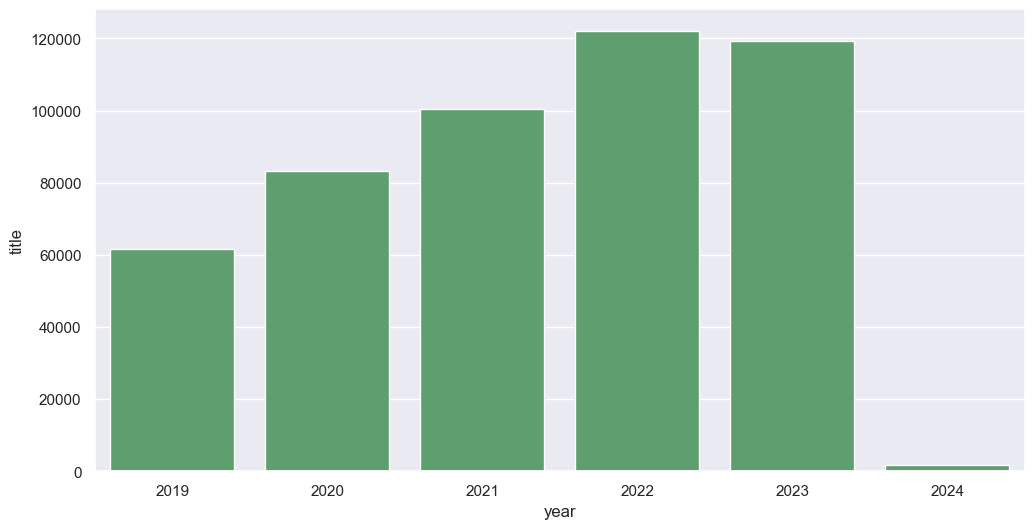

In [27]:
year_news = df[['year', 'title']].groupby(['year']).count().reset_index()
plt.figure(figsize=[12,6])
sns.barplot(x=year_news.year, y=year_news.title, color='g');

- Можем видеть, что по месяцам количество статей плавно увеличивается к декабрю. 
- По дням недели можно сделать вывод, что меньше новостей выпускаю в выходные.
- По годам можем видеть, что наибольшее количество новостей было в 2022 и наименьшее в 2024. Оно и не удивительно, 2024 год только начался. 

### Анализ по длиннам символов

Далее добавим в таблицу признаки с длинами заголовков и содержаний. Попробуем проанализировать, каким образом в разделах различаются размеры статей.

In [10]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

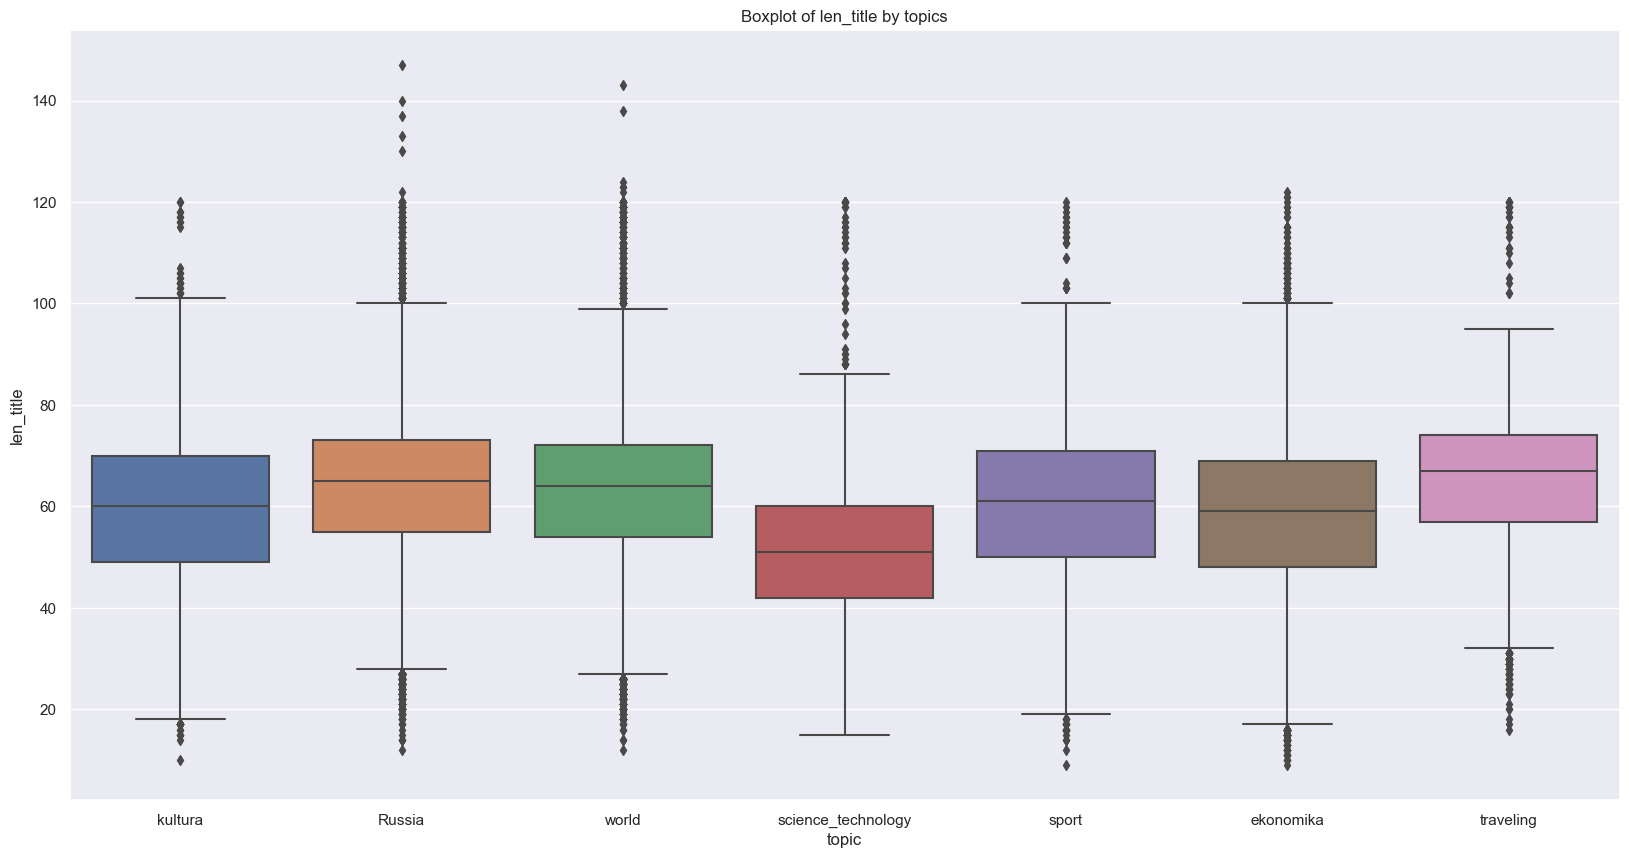

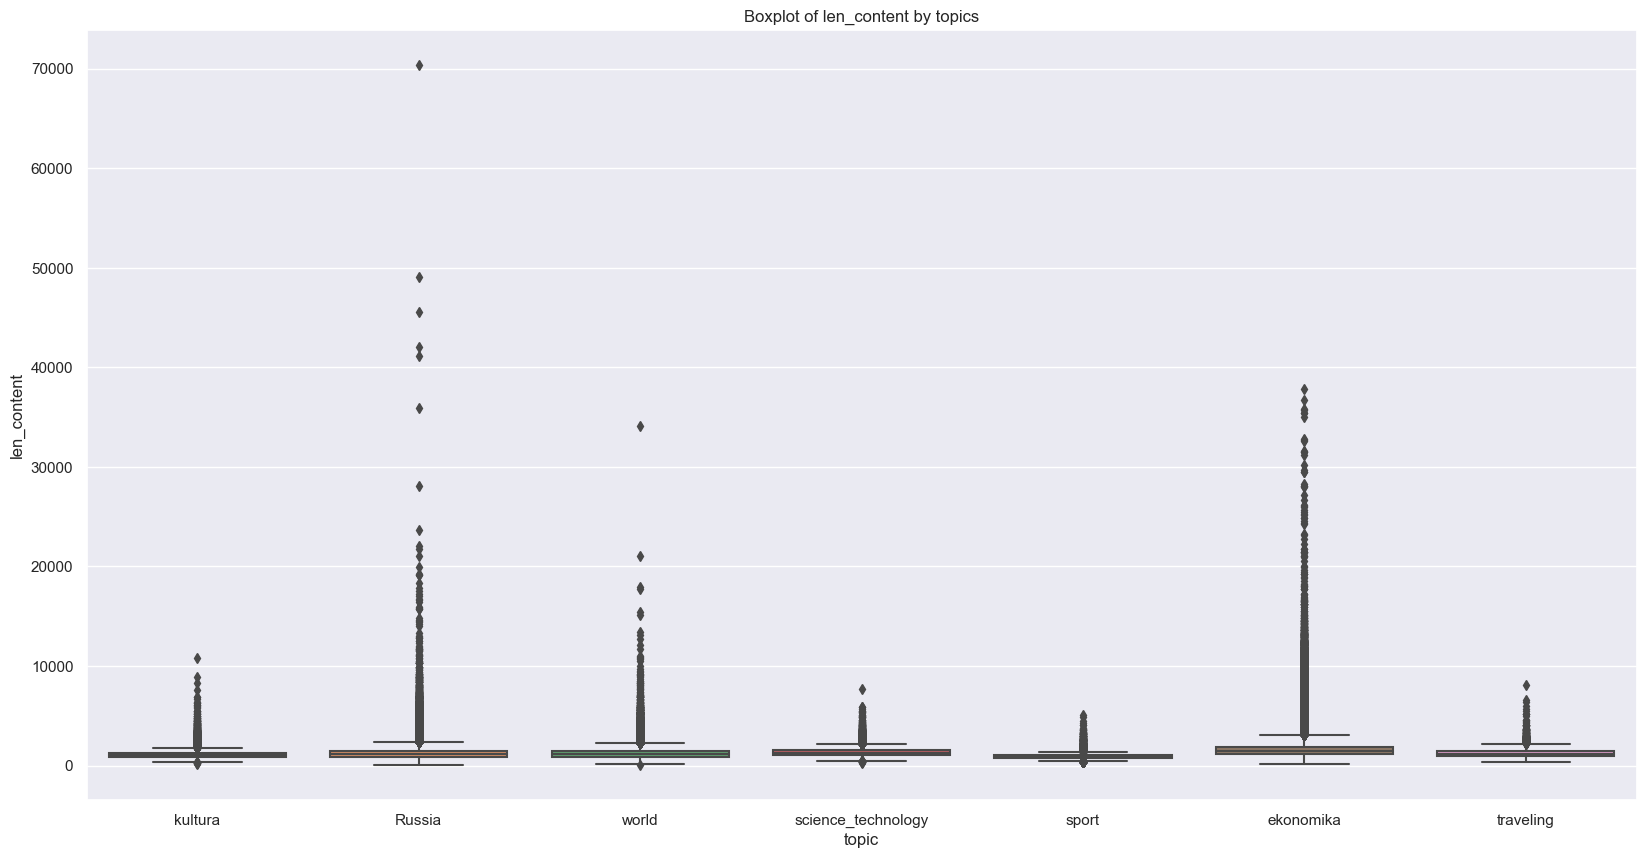

In [11]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

In [21]:
df.drop('date', axis=1).describe()

len_title    len_content
count  488135.000000  488135.000000
mean       61.303088    1336.373323
std        13.460810     930.940275
min         9.000000      54.000000
25%        52.000000     909.000000
50%        62.000000    1142.000000
75%        72.000000    1486.000000
max       147.000000   70351.000000

- Мы видим, что средняя длина заголовка равняется 61 знакам, а средняя длина статьи - 1336 знаков (при этом медиана - 930).
- Самыми объемными статьями оказались статьи из раздела "Russia", который содержит самое большое количество статей. Статьи из остальных разделов имеют примерно одинаковые длины статей.
- Присутствует некоторое количество выбросов в длинах заголовков и контенте.

Взглянем на то, какие ключевые слова присутствуют в заголовках каждой из тематик.

### Облако тегов

In [22]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'ноября', 'делать', 'рассказал'])

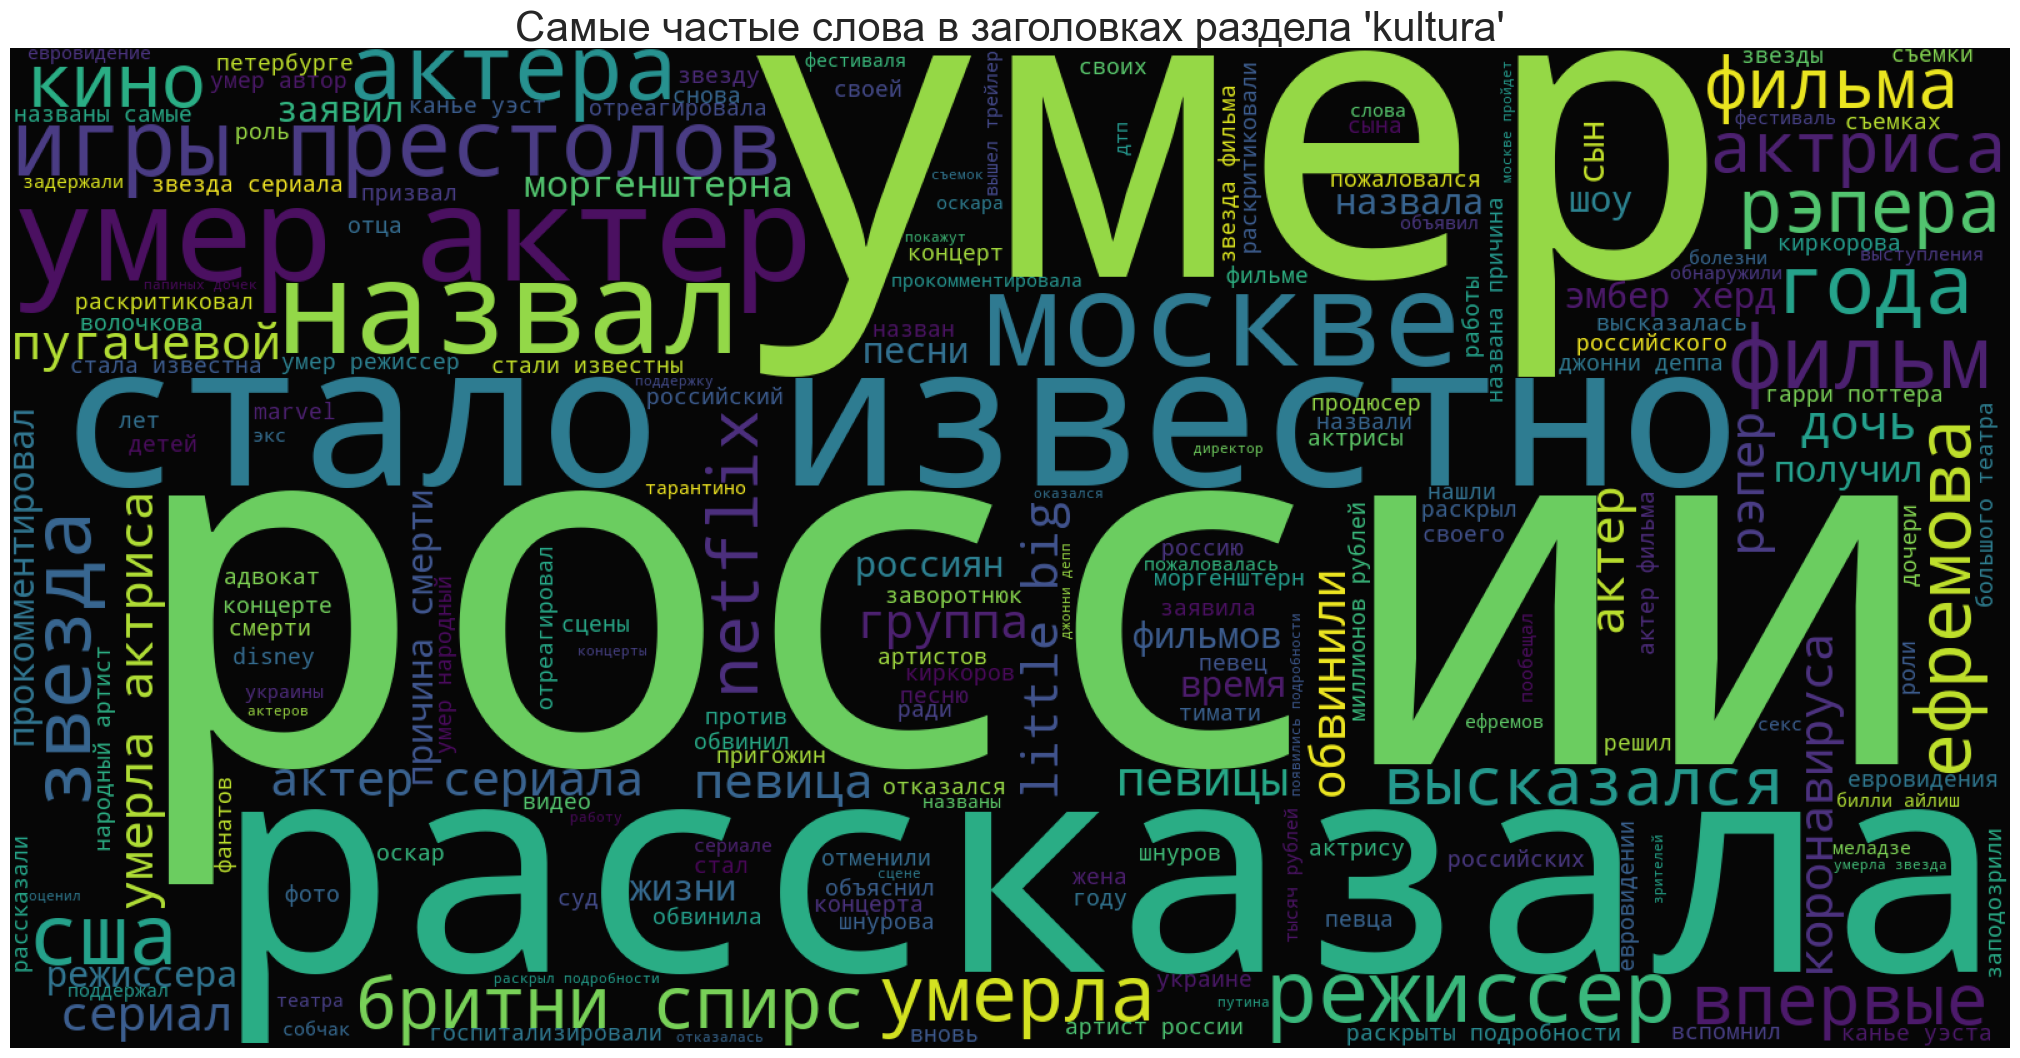

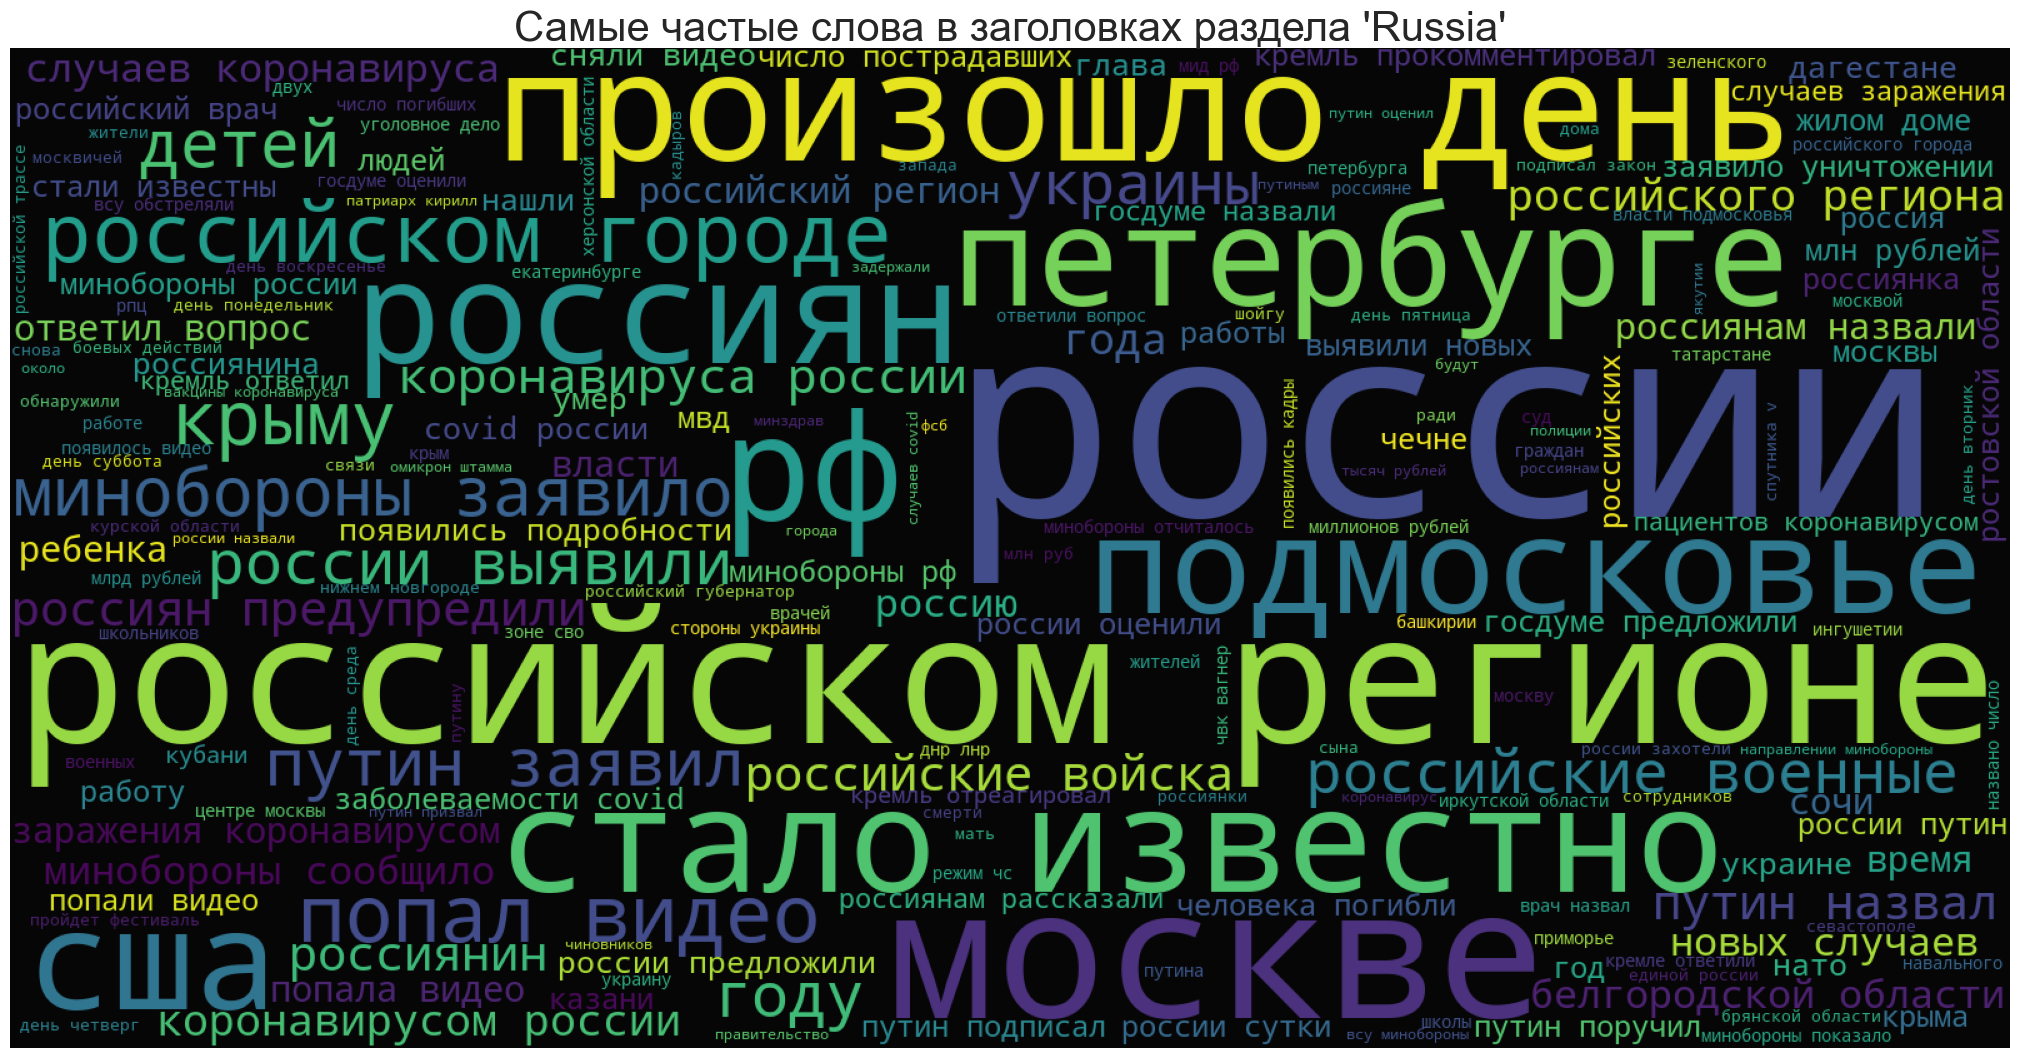

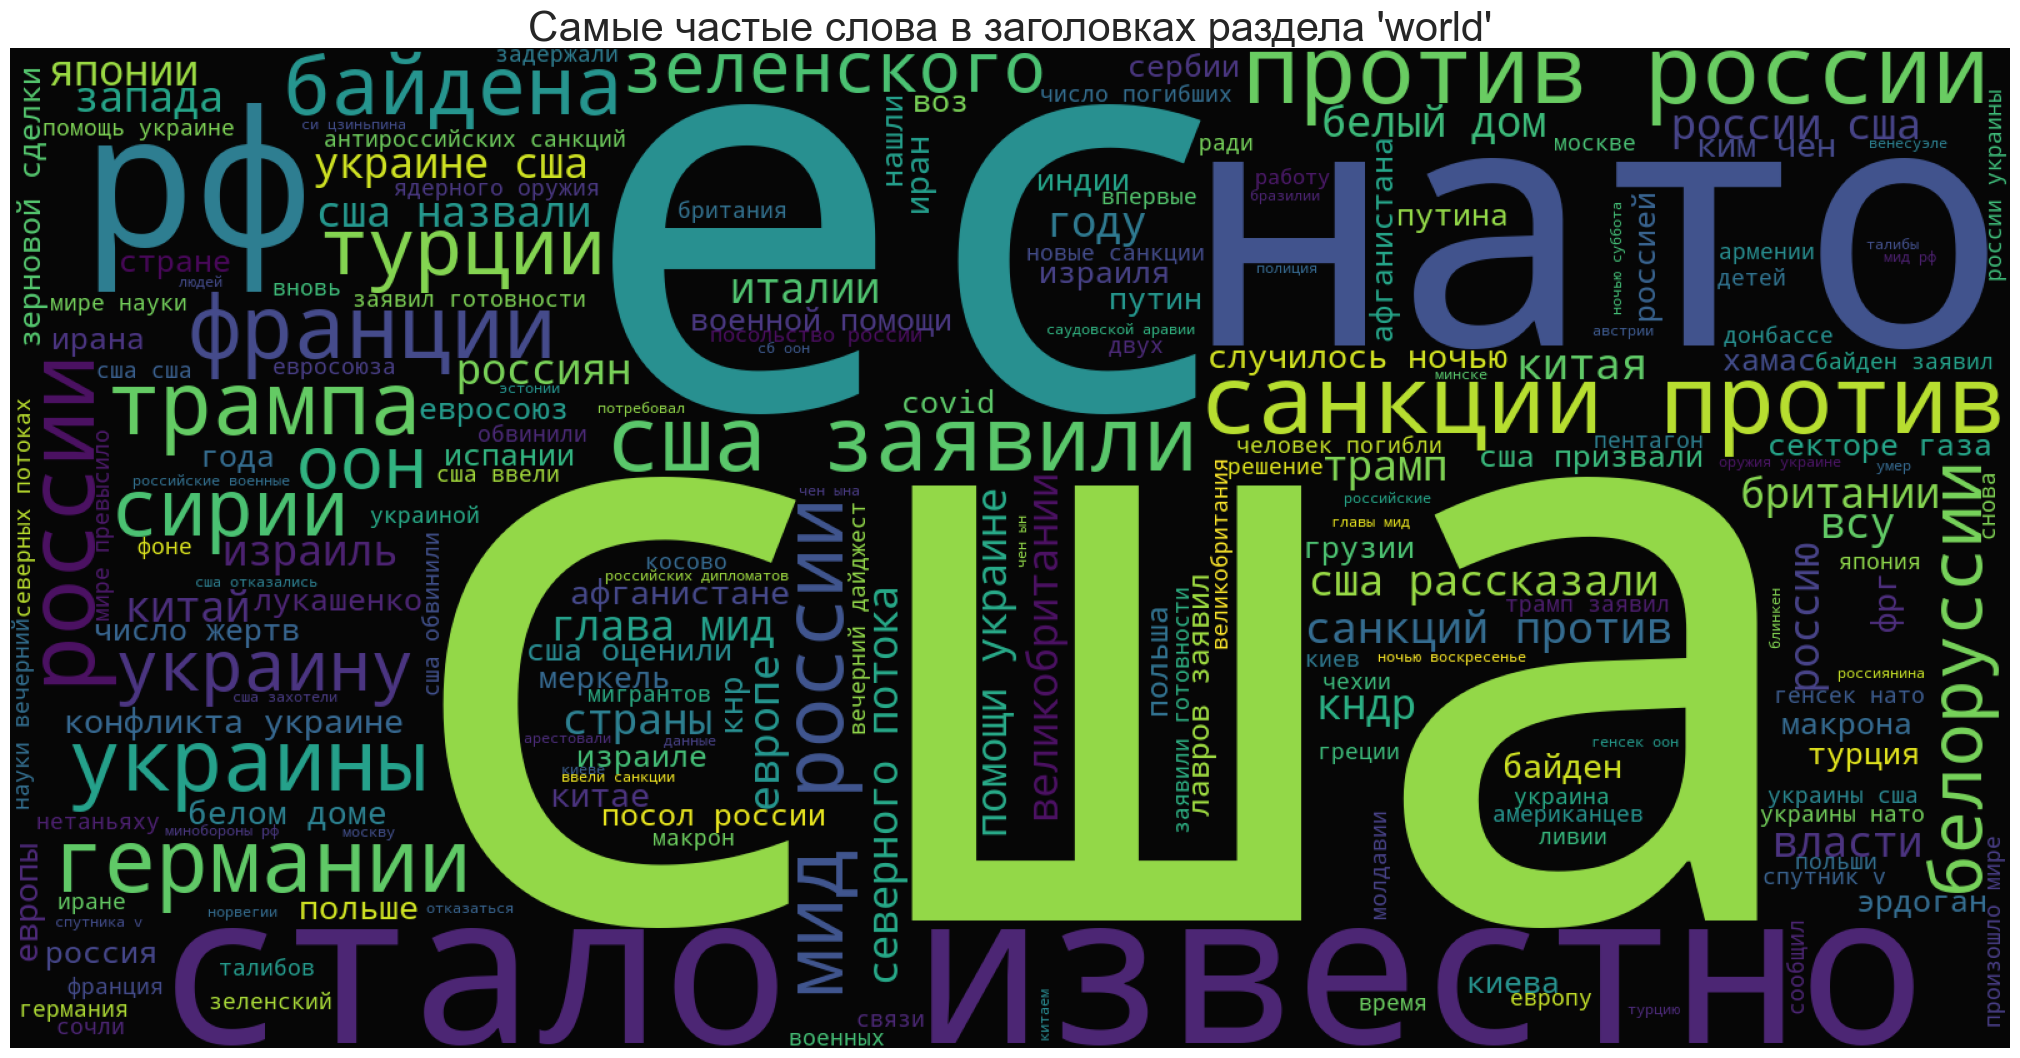

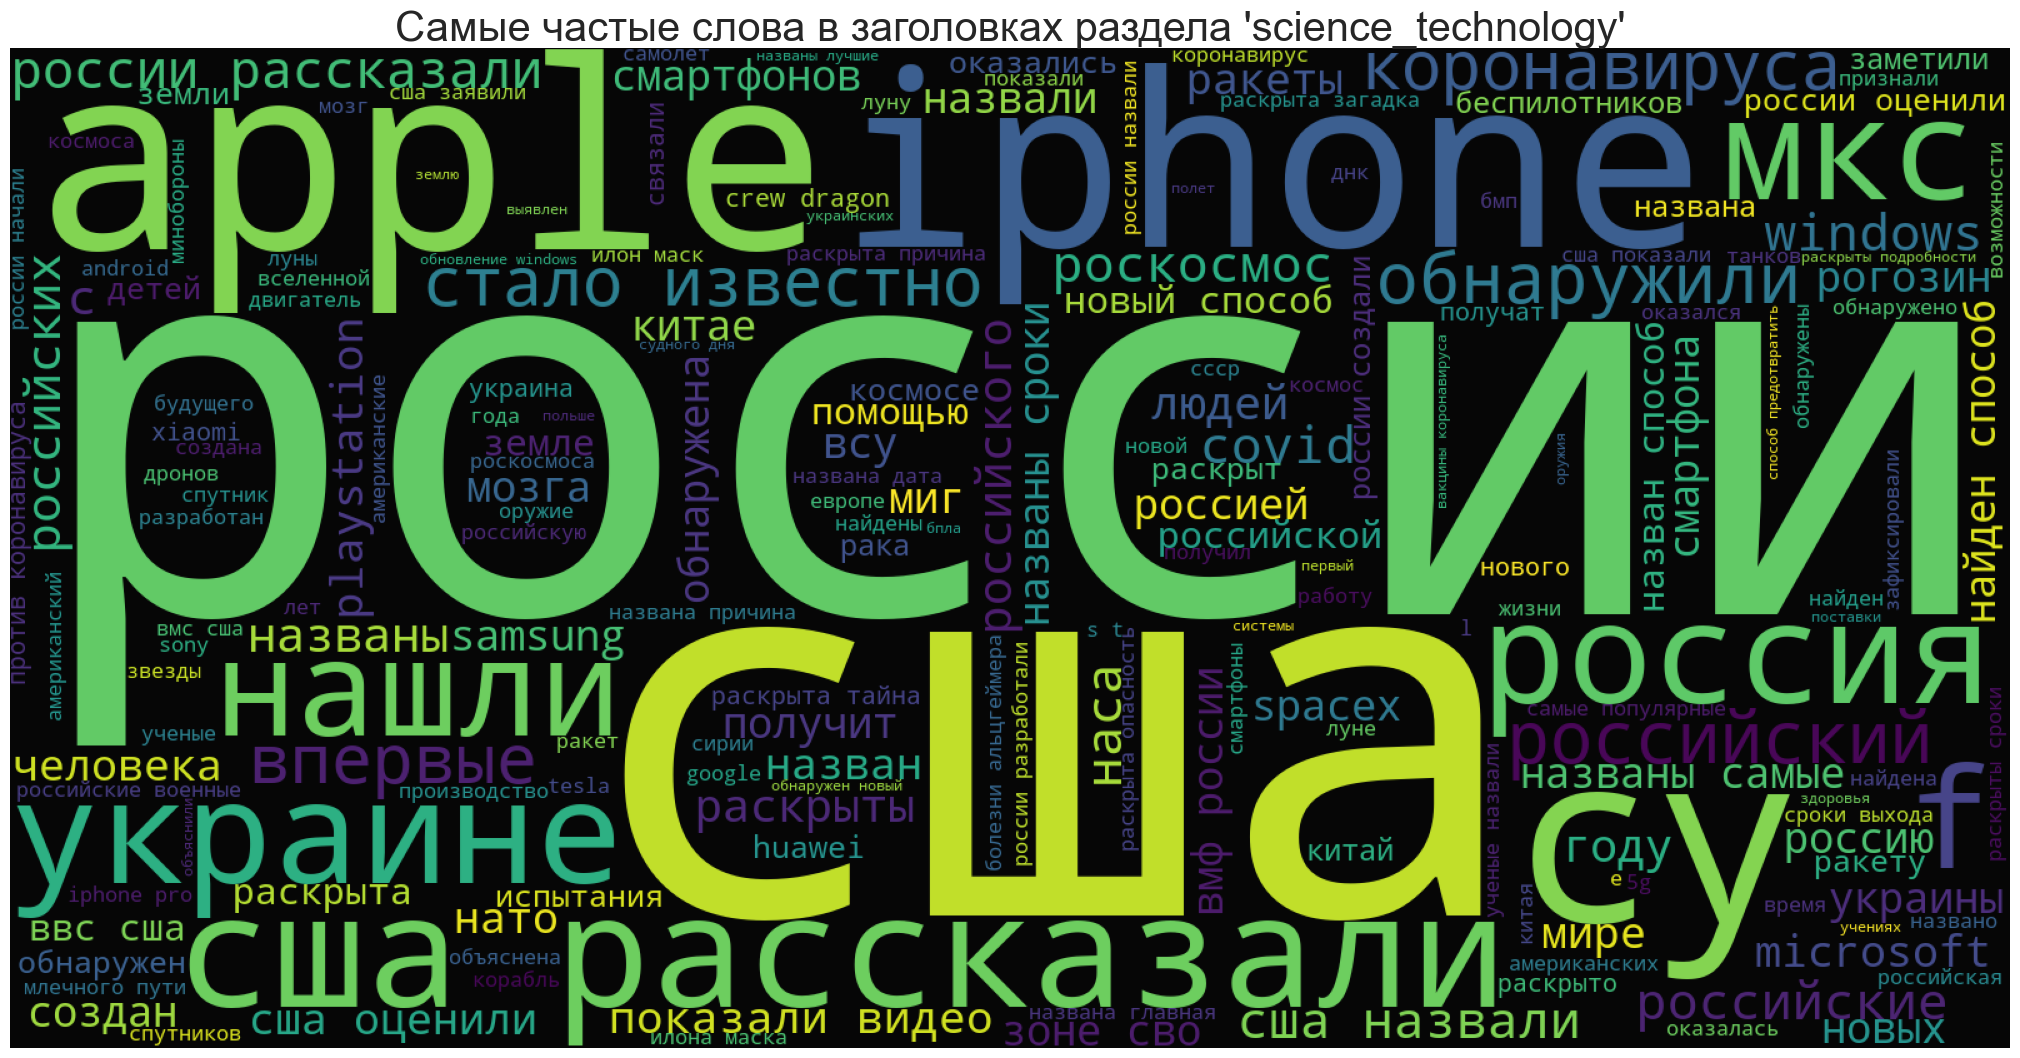

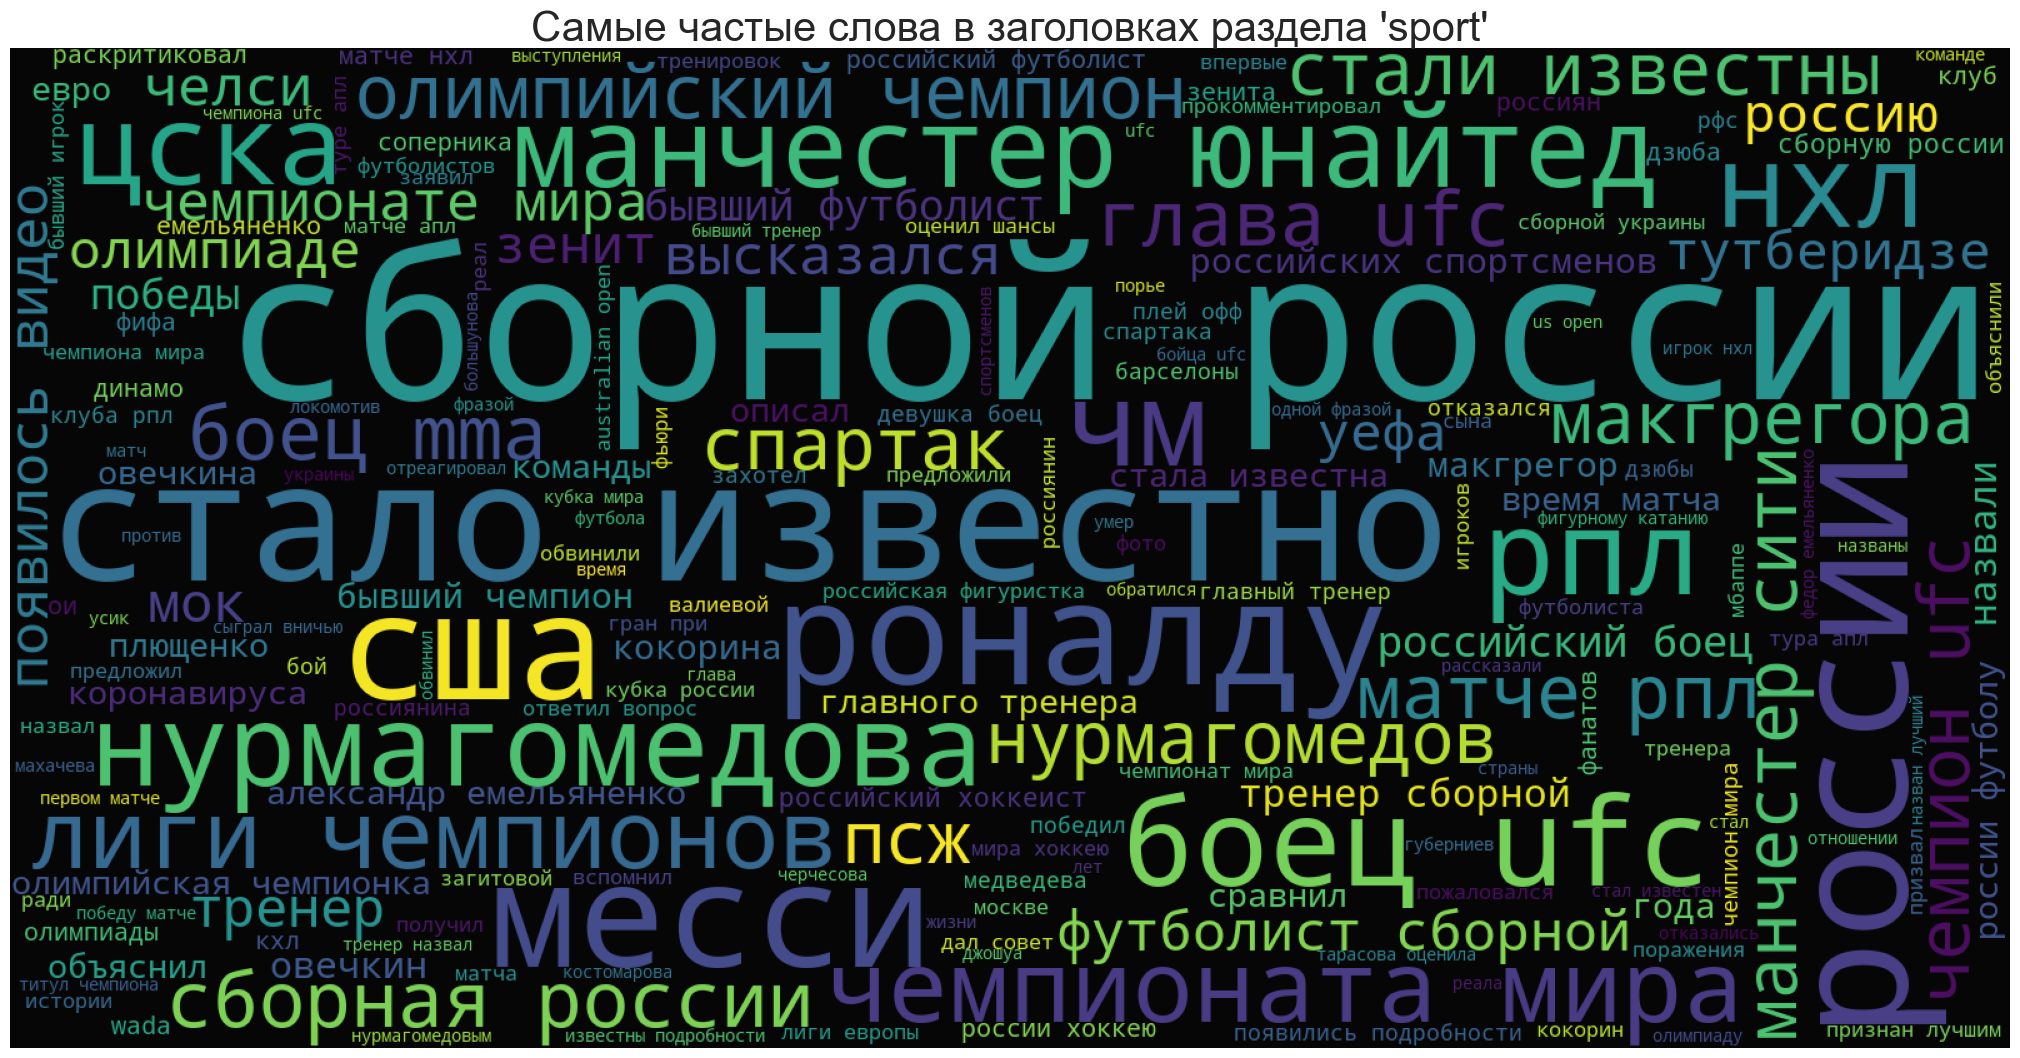

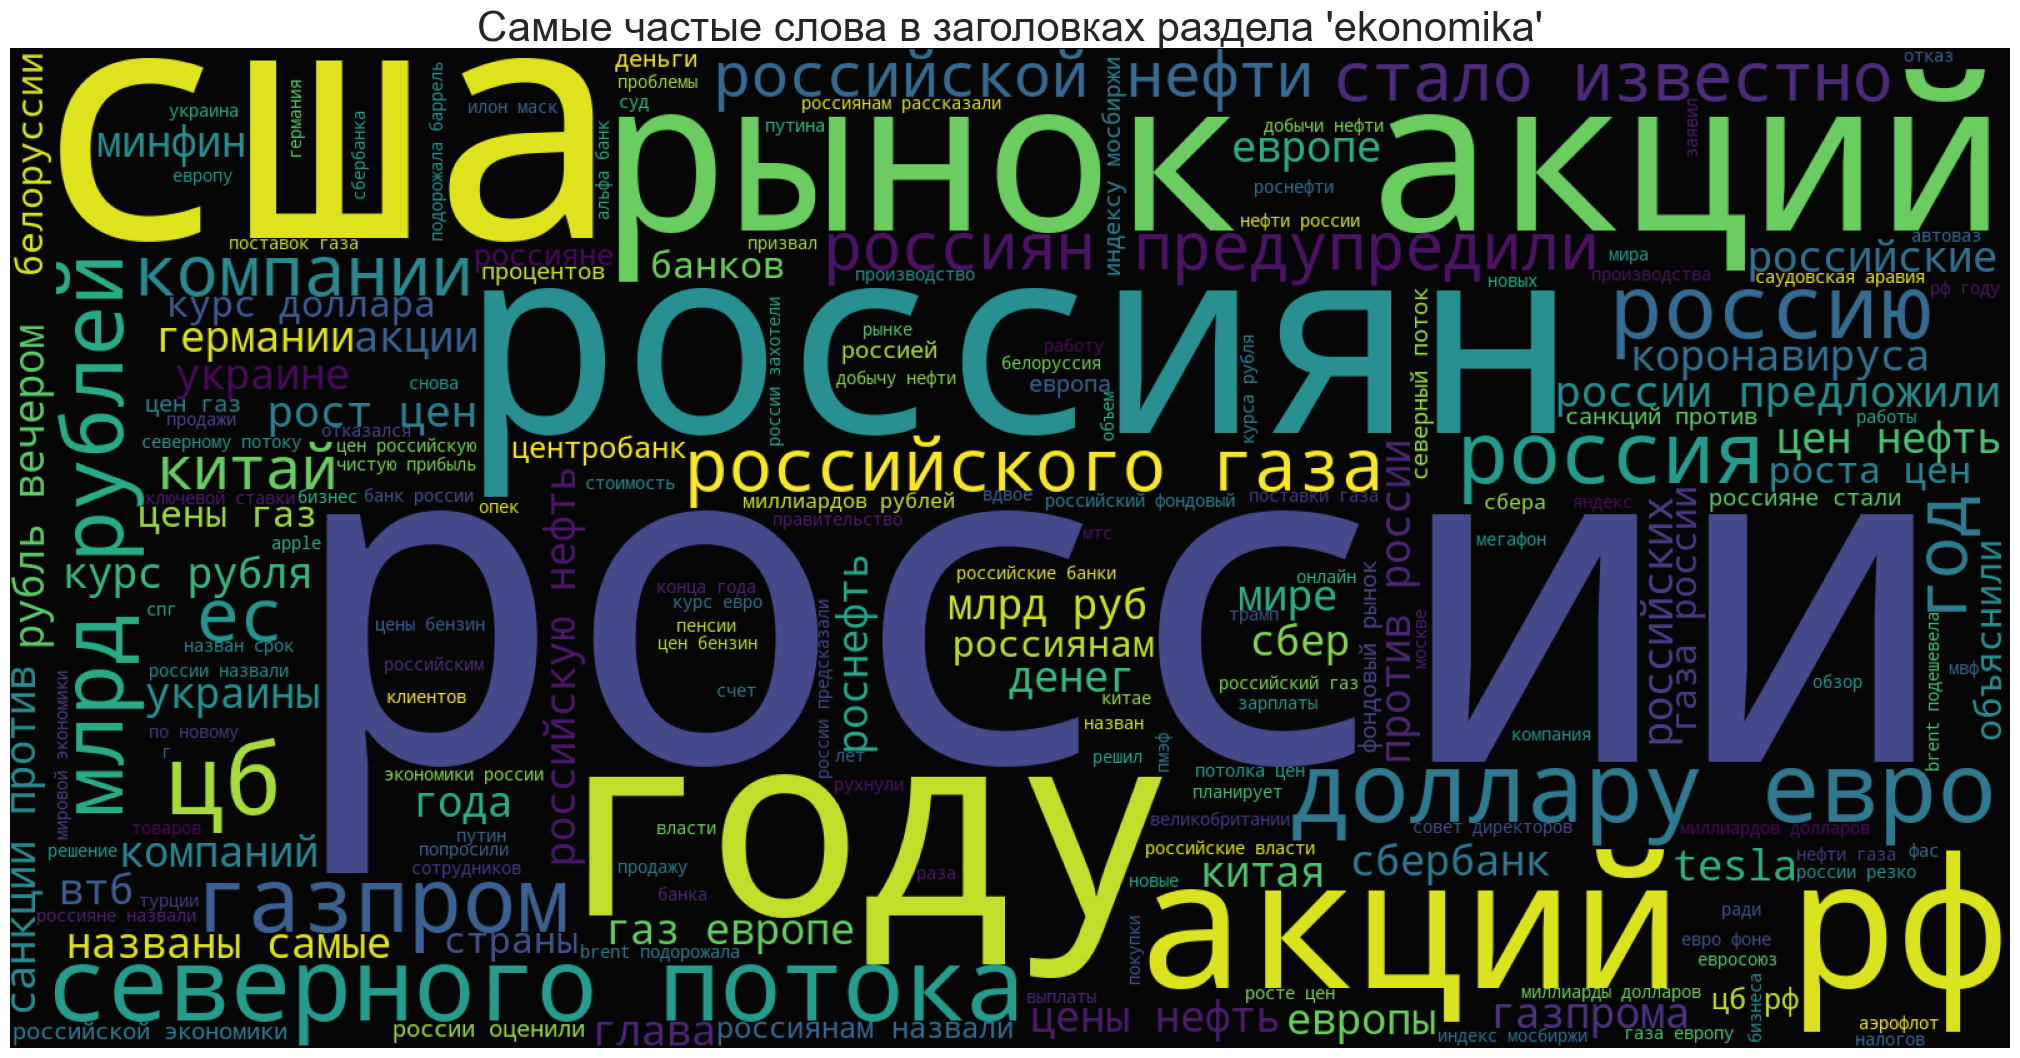

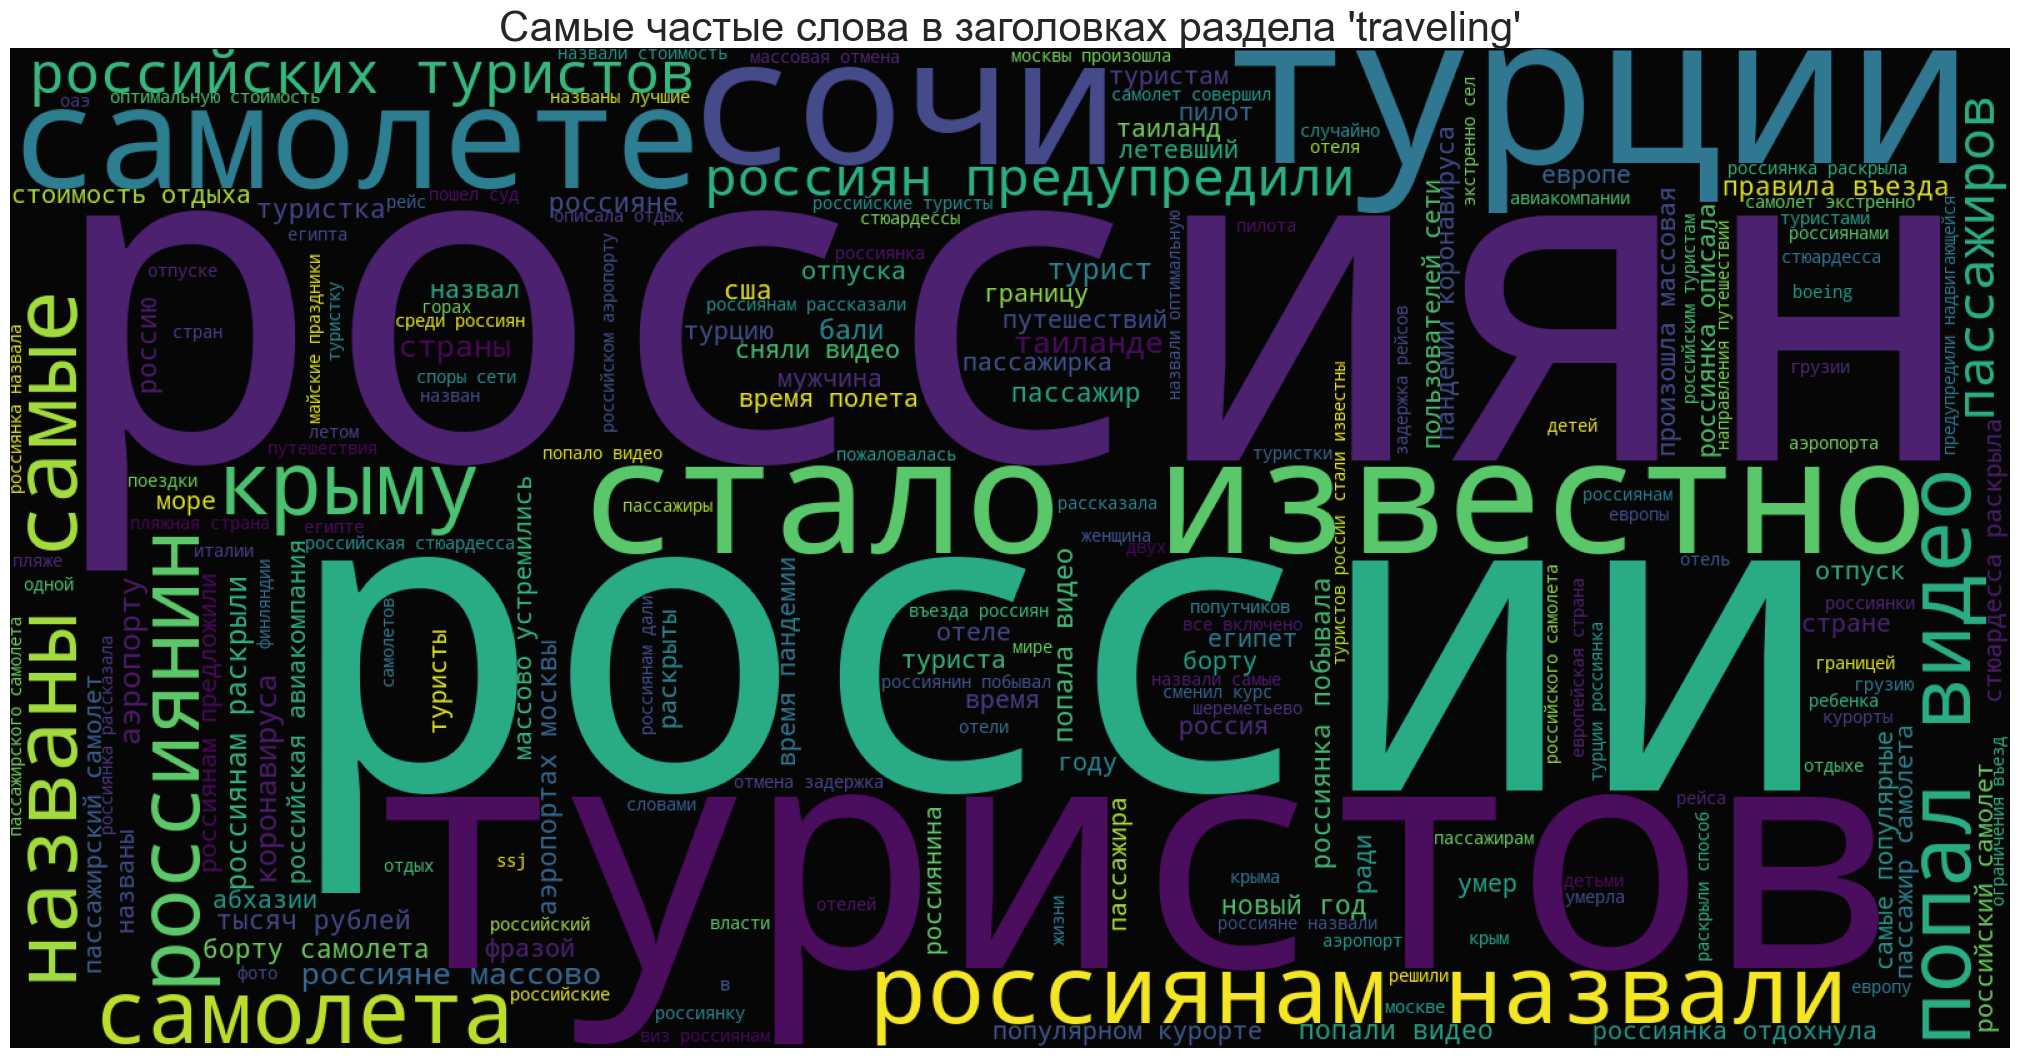

In [23]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Самые частые слова в заголовках раздела \'{topic}\'", fontsize=30)
    ax.imshow(wc, alpha=0.98)